In [1]:
import librosa
import matplotlib
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter

import soundfile as sf

import phast
import abt

from matlab import MatlabData
from utils import bin_over_y
from plotting import plot_pulse_train_stats

10.8230295
(80, 243)


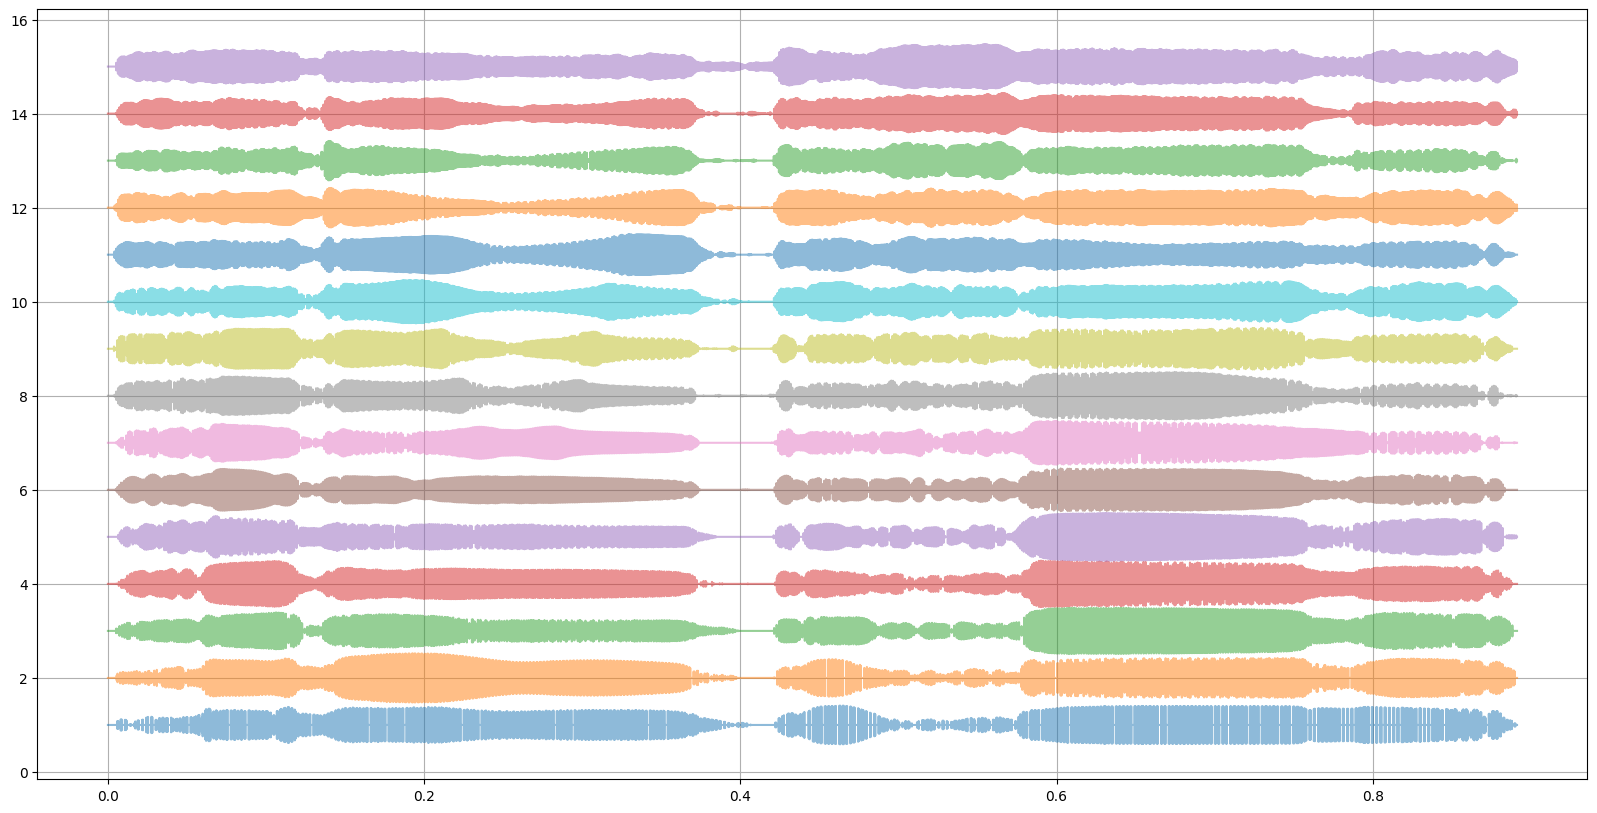

In [95]:
MIN_FREQ = 350
MAX_FREQ = 5000

FS = 17400
NAME = "defineit"
N_MELS = 80
N_FFT = 2048
N_HOP = N_FFT // 32
CS = False

MEL_SCALE = librosa.filters.mel_frequencies(N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ) 

MAT = MatlabData.read()

IDET = MAT.I_det[:, 4::8] if not CS else MAT.I_det
scaling_factor = 1.0

freq_f = scipy.interpolate.interp1d(
    np.r_[0, np.argmin(MAT.I_det[:,::8], axis=0), 3200], 
    np.r_[0, abt.utils.virtual_channel_frequencies(16), MAX_FREQ], 
    fill_value='extrapolate'
)

fidx = np.arange(0, 3200)
int_freq = freq_f(fidx)

pulse_train, audio_signal = abt.wav_to_electrodogram(
    abt.sounds[NAME], 
    current_steering=CS, 
    charge_balanced=False,   
    virtual_channels=True,
    apply_audiomixer=False,
    ramp_type = None,
    # M=MAT.M * 1e6 / scaling_factor,
    # T=MAT.T * 1e6 / scaling_factor,
    Fs = FS,
    # stim_db = 62.0,
    # ramp_duration=0.1
)
# pulse_train *= scaling_factor

audio_signal = audio_signal[0]
duration = len(audio_signal) * (1 / FS)

cycle = 2 * 15
cycle_time = cycle * 18e-6
n_channels = pulse_train.shape[0]
channel_freq = abt.utils.virtual_channel_frequencies(n_channels, MAX_FREQ)

S = librosa.feature.melspectrogram(y=audio_signal, sr=FS, n_fft=N_FFT, hop_length=N_HOP, n_mels=N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ)
ref_db = np.max(S)
print(ref_db)
print(S.shape)
# plot_pulse_train_stats(pulse_train, audio_signal, MAT, IDET, FS) 

plt.figure(figsize=(20, 10))

t = np.linspace(0, duration, pulse_train.shape[1])
for i, channel in enumerate(pulse_train, 1):
    mask = np.where(channel)[0]
    y = np.ones(pulse_train.shape[1]) * i
    y[mask] += 1e3 * channel[mask]
    y[mask+1] -= 1e3 * channel[mask]
    plt.step(t, y, alpha=.5)
plt.grid()



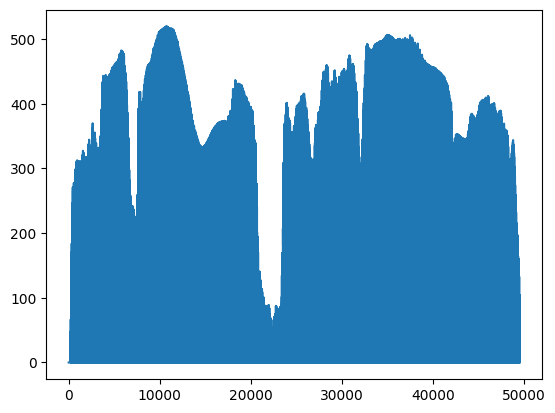

In [91]:
plt.plot(pulse_train.sum(axis=0) * 1e6)

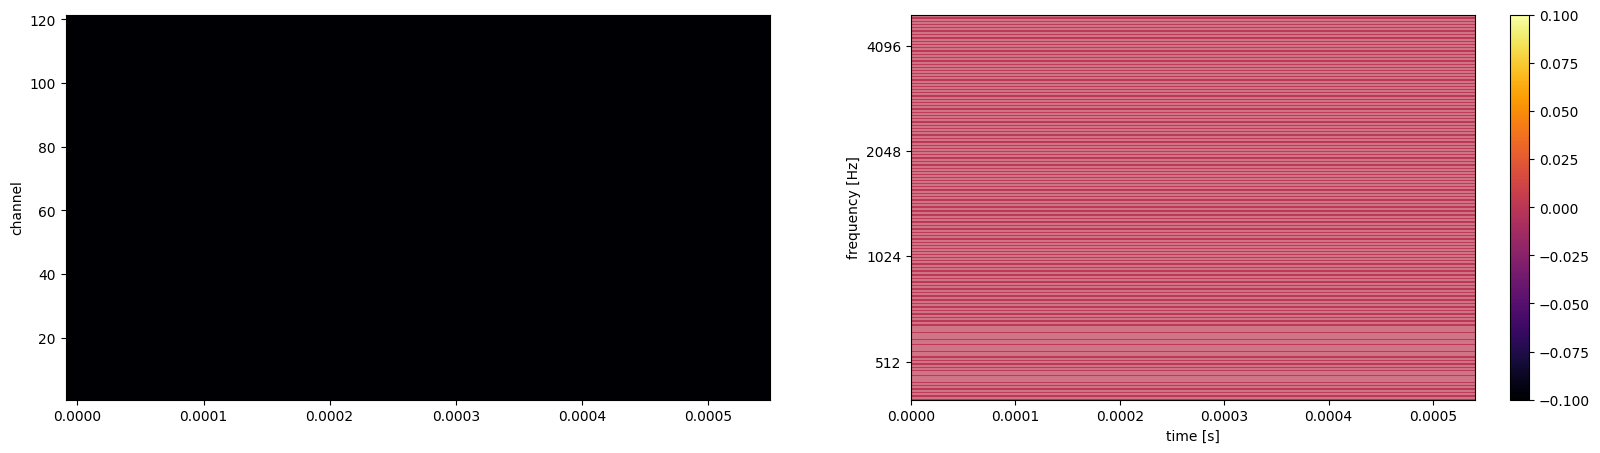

In [36]:
cycle = 2 * 15
cycle_time = cycle * 18e-6
n_channels = pulse_train.shape[0]
n_th = 0
single_cycle = pulse_train[:, n_th * cycle: (n_th + 1) * cycle]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.pcolormesh(np.linspace(0, cycle_time, cycle), np.arange(1, n_channels+1), single_cycle, cmap="inferno")
ax1.set_ylabel("channel")
ax2.set_xlabel("time [s]")

abt.utils.plot_heatmap(
    np.linspace(0, cycle_time, cycle),
    channel_freq,
    single_cycle,
    ax=ax2,
    fig=f
)

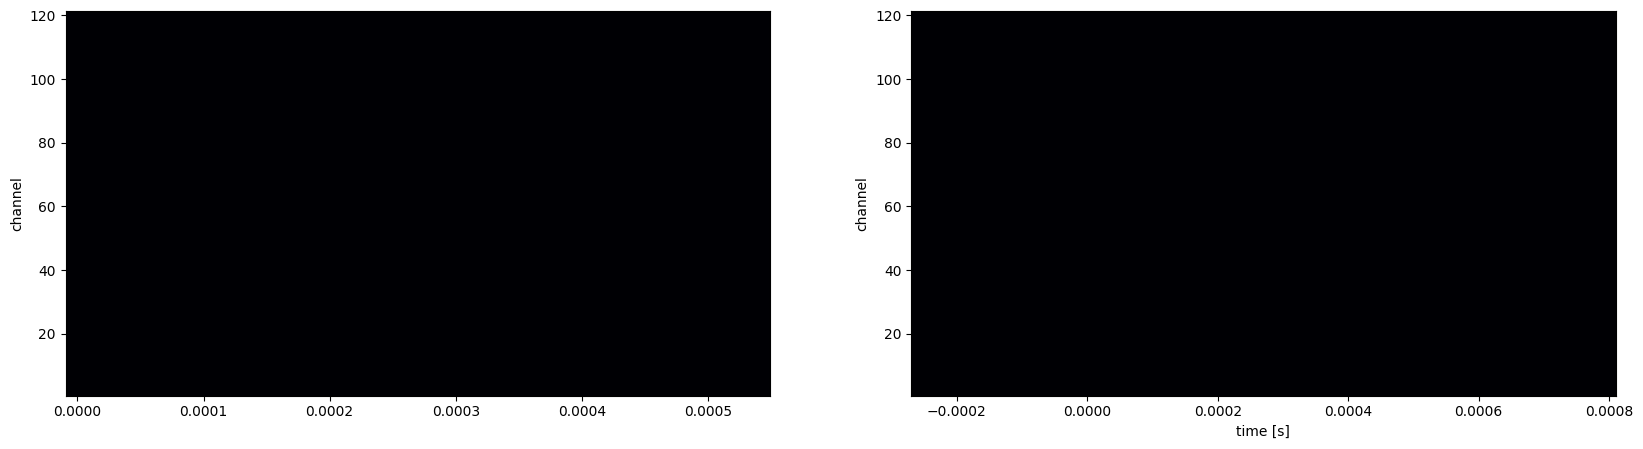

In [37]:
filt = abt.utils.apply_filter(single_cycle, window_size=cycle, hop_length=cycle, scale=False)
filt = np.c_[np.zeros(n_channels), filt]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.pcolormesh(np.linspace(0, cycle_time, cycle), np.arange(1, n_channels+1), single_cycle, cmap="inferno")
ax1.set_ylabel("channel")
ax2.set_xlabel("time [s]")

ax2.pcolormesh(
    np.linspace(0, cycle_time, filt.shape[1]), 
    np.arange(1, n_channels+1), 
    filt, 
    cmap="inferno"
)
ax2.set_ylabel("channel")
ax2.set_xlabel("time [s]");

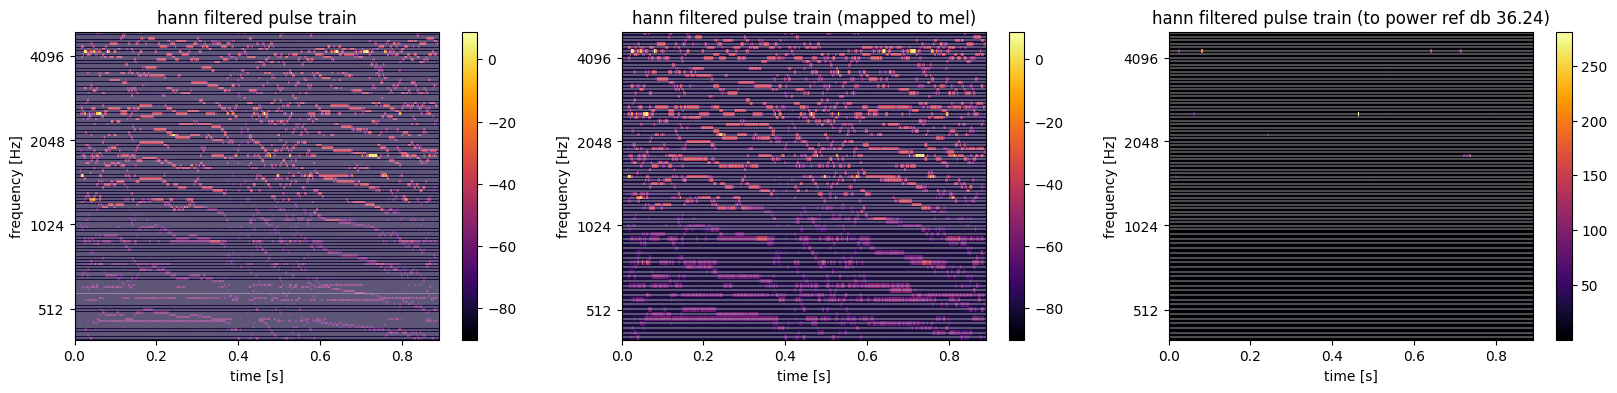

In [48]:
n_cycles = 4
n_cycle_hop = max(n_cycles // 4, 1)

pt_cyc = abt.utils.apply_filter(
    pulse_train, 
    window_size=n_cycles * cycle, 
    hop_length=n_cycle_hop * cycle, 
    scale=True, 
    resample_to=S.shape[1],
    clip_outliers=.997
)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

abt.utils.plot_heatmap(
    np.linspace(0, duration, pt_cyc.shape[1]),
    channel_freq,
    pt_cyc,
    ax=ax1, fig=f
)
ax1.set_title(f"hann filtered pulse train")

y_binned = bin_over_y(pt_cyc, channel_freq, MEL_SCALE)

t = np.linspace(0, duration, len(y_binned[0]))
abt.utils.plot_heatmap(t, MEL_SCALE, y_binned, ax=ax2, fig=f)
ax2.set_title(f"hann filtered pulse train (mapped to mel)")

ref_db = np.max(S)
mel_spec_ng = librosa.db_to_power(y_binned, ref=ref_db)
abt.utils.plot_heatmap(t, MEL_SCALE, mel_spec_ng, ax=ax3, fig=f)
ax3.set_title(f"hann filtered pulse train (to power ref db {ref_db:.2f})");

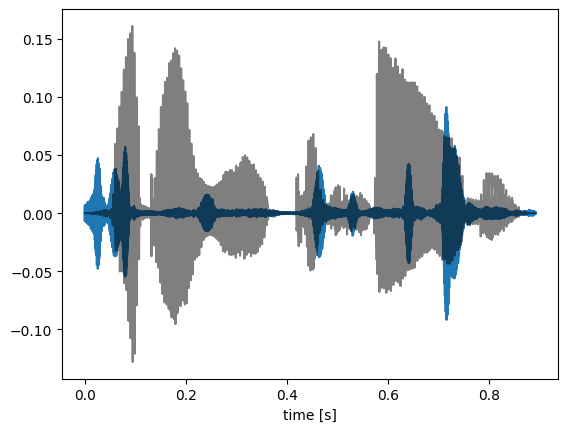

In [49]:
mel_inversed = librosa.feature.inverse.mel_to_audio(
    mel_spec_ng, n_fft=N_FFT, hop_length=N_HOP, sr=FS, fmin=MIN_FREQ, fmax=MAX_FREQ
)
mel_inversed = scipy.signal.resample(mel_inversed, audio_signal.size)
    

t_mel = np.arange(len(mel_inversed)) * 1 / FS
plt.plot(t_mel, mel_inversed)

t_audio = np.arange(len(audio_signal)) * 1 / FS
plt.plot(t_audio, audio_signal, label="original signal", color="black", alpha=.5)
plt.xlabel("time [s]")

sf.write(
    f"output/elec_reconstructed_{NAME}_ci.wav", mel_inversed, FS, subtype='PCM_24'
)